## 1. Synthetic data logistic regression

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.model_selection import train_test_split

In [2]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)        
        self.n_batches = n_batches
    
    def forward(self, X):
        return np.dot(X, self.weights)
    
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
   
    def update(self):    
        return self.weights - self.lr*self.grad
    
   
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
   
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
   
    def score(self, X, y):    
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
   
    def fit(self, X, y):
        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None:
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad = np.zeros(self.weights.shape)
        self.cost = np.zeros(self.epochs)

        if self.batch_size is None:  
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs):
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 
                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)

                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        self.bias = self.weights[0]
   
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)
        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
   
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [3]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

In [4]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    X, y = ds
    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)

    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)

    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)
   
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [5]:
def make_binary_clf(N, method = 'line', noises = 0.15, random_state = 42):
    if random_state: rng = np.random.RandomState(seed = random_state)
    
    if method == 'line' or method is None:
        X, y = make_classification(n_samples=N, 
                                   n_features=2, 
                                   n_redundant=0, 
                                   n_informative=2,
                                   n_clusters_per_class=1, 
                                   class_sep=2, 
                                   random_state=random_state 
                                   )
        X += np.random.randn(*X.shape) *noises 
    
    elif method == 'moons':
        X, y = make_moons(n_samples=N, 
                          noise=noises, 
                          random_state=random_state 
                          )
    
    elif method == 'circles':  
        X, y = make_circles(n_samples=N, 
                            noise=noises, 
                            factor=0.5, 
                            random_state=random_state 
                            )
    
    return X, y

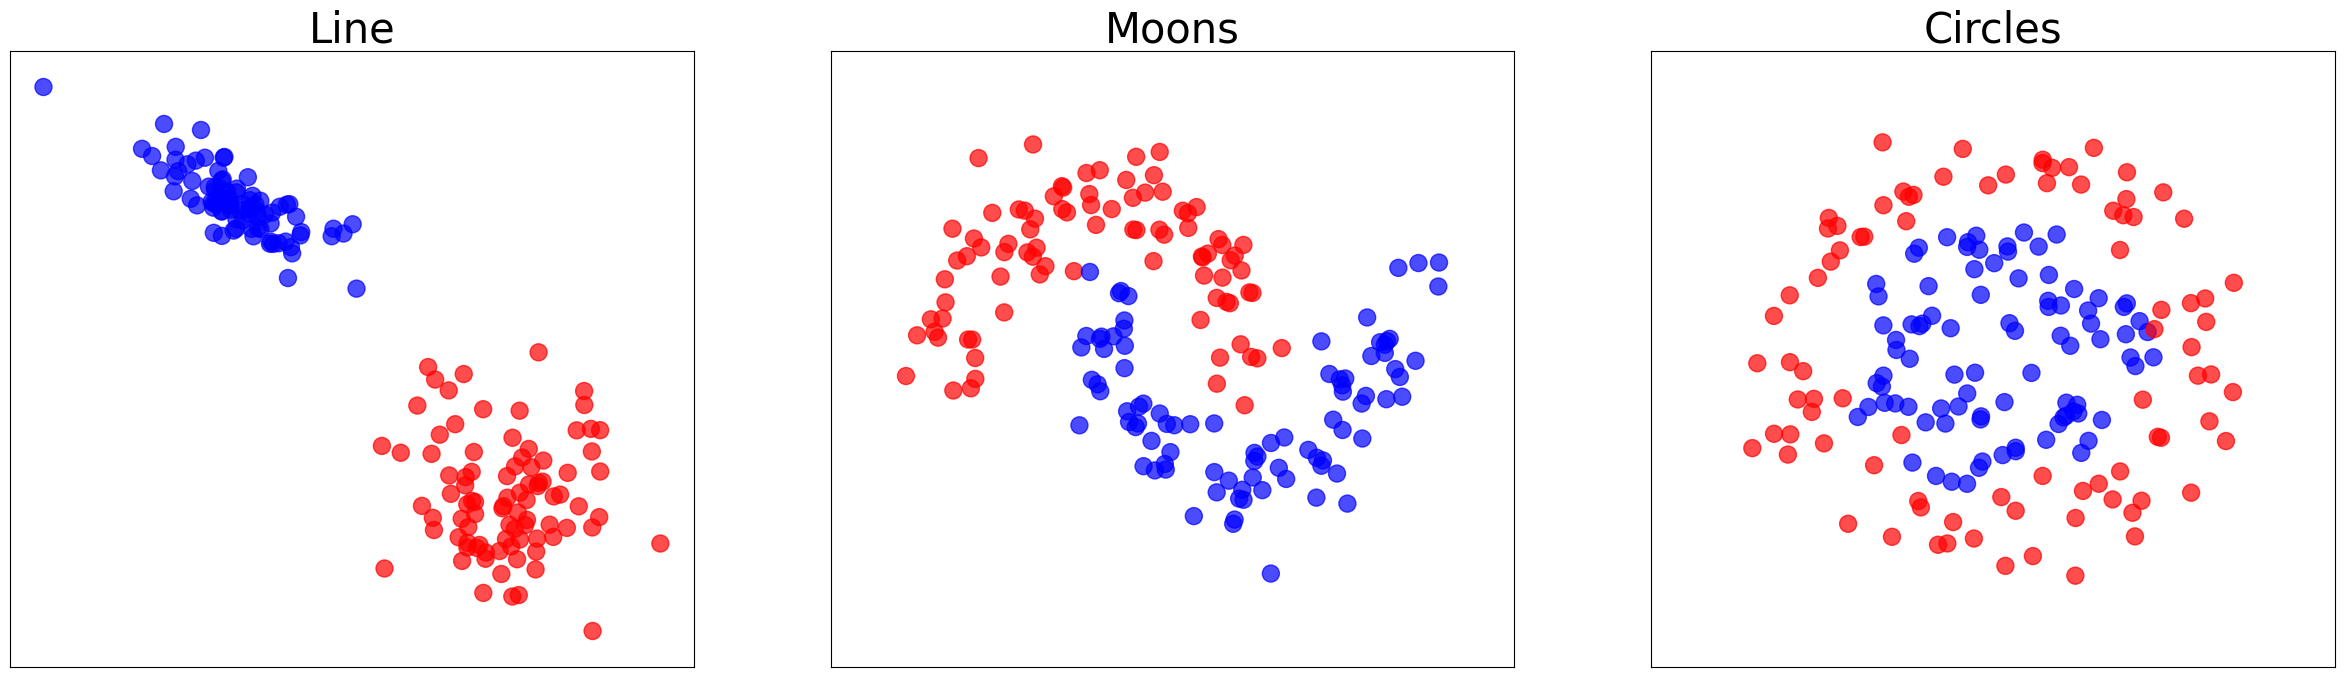

In [6]:
#@title Synthetic data generation { run: "auto" }
N = 175 #@param {type:"slider", min:50, max:250, step:25}
noises = 0.5 #@param {type:"slider", min:0, max:1, step:0.05}
random_state = 33

fig=plt.figure(figsize=(30,8))

ax = plt.subplot(1, 3, 1)
linear_1_x, linear_1_y = make_binary_clf(N,method = 'line', random_state=random_state)
plot_data(ax, (linear_1_x, linear_1_y),
          'Line')

ax = plt.subplot(1, 3, 2)
moons_1_x, moons_1_y = make_binary_clf(N,method = 'moons', random_state=random_state)
plot_data(ax, (moons_1_x, moons_1_y), 
          'Moons')

ax = plt.subplot(1, 3, 3)
circles_1_x, circles_1_y = make_binary_clf(N,method = 'circles', random_state=random_state)
plot_data(ax, (circles_1_x, circles_1_y),
          'Circles')

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z)) 

In [8]:
def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z)) 

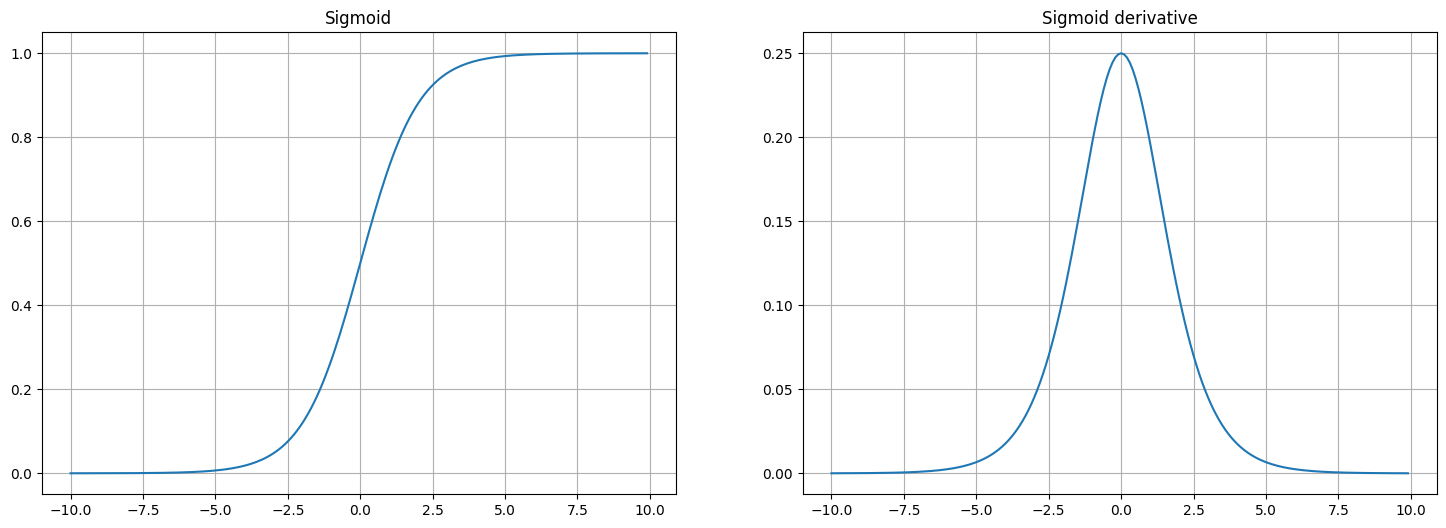

In [9]:
z = np.arange(-10,10,0.1)

plt.figure(figsize=(18,6))
plt.subplot(121); 
plt.plot(z,sigmoid(z))
plt.title('Sigmoid')
plt.grid()
plt.subplot(122); 
plt.plot(z,sigmoid_derivative(z))
plt.title('Sigmoid derivative')
plt.grid()

In [10]:
def to_class(logit, threshold = 0.7):
    return (logit >= threshold) * 1

In [11]:
print( to_class(sigmoid(0.5), threshold = 0.6), ',',  to_class(sigmoid(-2.5), threshold = 0.7) , ',', to_class(sigmoid(2), threshold = 0.8))

1 , 0 , 1


In [12]:
_EPS_ = 1e-6
def bce_loss(yhat, y):
    return -(y*np.log(yhat + _EPS_)+(1 - y)*np.log(1 - yhat + _EPS_)).mean()

In [13]:
print('Неопределенность - попали ровно в 0.5 (yhat=0.5, y=1):\t %.3f' % bce_loss(yhat=0.5, y=1))
print('Неопределенность - попали ровно в 0.5 (yhat=0.5, y=0):\t %.3f' % bce_loss(yhat=0.5, y=0))
print('Правильно предсказываем 0 класс (yhat=0, y=0):\t %.3f' % bce_loss(yhat=0.0, y=0))
print('Правильно предсказываем 1 класс (yhat=1, y=1):\t %.3f' % bce_loss(yhat=1, y=1))
print('Неправильно предсказываем 0 класс (yhat=0, y=1):\t %.3f' % bce_loss(yhat=0.0, y=1))
print('Неправильно предсказываем 1 класс (yhat=1, y=0):\t %.3f' % bce_loss(yhat=1, y=0))

Неопределенность - попали ровно в 0.5 (yhat=0.5, y=1):	 0.693
Неопределенность - попали ровно в 0.5 (yhat=0.5, y=0):	 0.693
Правильно предсказываем 0 класс (yhat=0, y=0):	 -0.000
Правильно предсказываем 1 класс (yhat=1, y=1):	 -0.000
Неправильно предсказываем 0 класс (yhat=0, y=1):	 13.816
Неправильно предсказываем 1 класс (yhat=1, y=0):	 13.816


In [14]:
def to_polynom(X, order = 2):
    if order <2:
        order = 2 

    order_range = range(2, order+1,1)
    out = np.copy(X) 
    for i in order_range:
        out = np.hstack([out, np.power(X,i)])
    return out

In [15]:
class LogisticRegression(ElasticRegression):  
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias = None, 
                 threshold = 0.5,
                 batch_size = 1000, 
                 n_batches = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold

    def loss(self,yhat, y):
        l1_term = self.l1_penalty*np.sum(self.weights[1:])
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term   

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))     

    def forward(self, X):    
        return self.sigmoid(np.dot(X, self.weights))   

    def to_class(self,logit):
        return (logit>=self.threshold)*1   

    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return self.to_class(yhat)

    def predict_prob(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat

    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
   
    def plot_desicion_function(self,X,y,figsize = (12,6),
                               marker = 'o',colors =("#FF0000", '#0000FF'),
                               alpha=0.7, s = 150, poly = False, order = 2):
        plt.figure(figsize = figsize)
        cm_bright = ListedColormap(colors)
        plt.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha);

        h =  (X[:, 0].max() - X[:, 0].min())/50
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))

        if poly:
            Z = self.predict_prob(to_polynom(np.c_[xx.ravel(), yy.ravel()],order))-0.5
           
        else:
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()])-0.5
           
        cm = plt.cm.RdBu
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()
   
    def classification_report(self, X,y):
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        
        yhat  = self.predict(X)
        total = yhat.size
        n = sum(yhat==0)
        p = sum(yhat==1)
       
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.4f'%(tp/p), end = '\t')
        print('True Negatives:%.4f'%(tn/n))
        print('False Positives:%.4f'%(fp/p), end = '\t')
        print('False Negatives:%.4f'%(fn/n))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

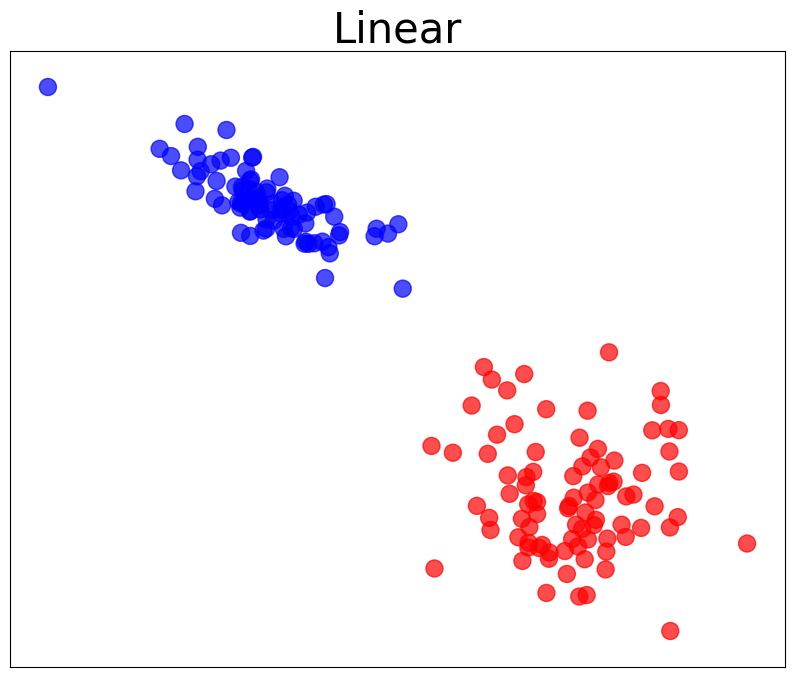

In [16]:
X_train, X_test, y_train, y_test = train_test_split(linear_1_x, linear_1_y, test_size=0.3, random_state=42)

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 1, 1)
plot_data(ax, (linear_1_x, linear_1_y), 'Linear')

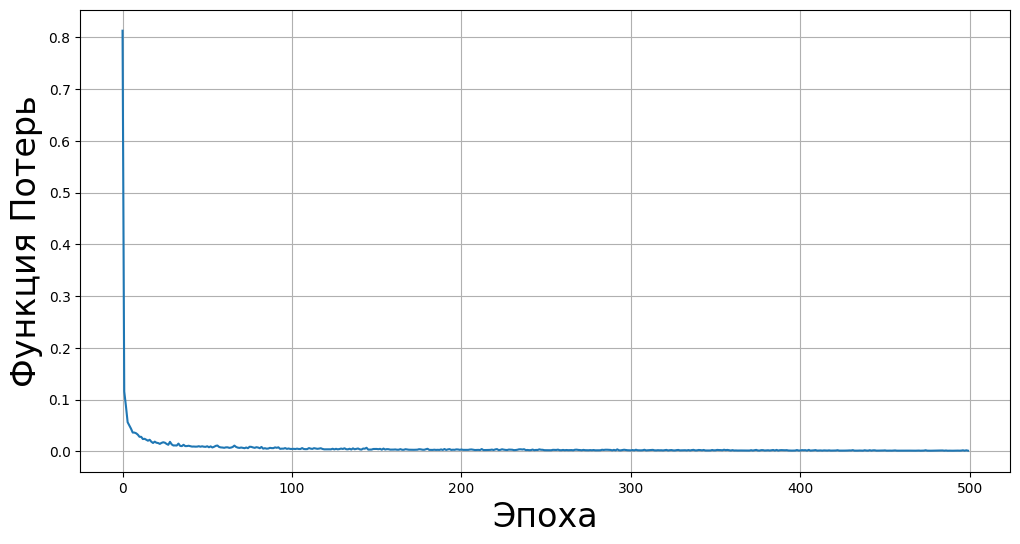

1.0 1.0
True Positives:1.0000	True Negatives:1.0000
False Positives:0.0000	False Negatives:0.0000
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000


In [17]:
regr = LogisticRegression(learning_rate=0.25, epochs=500,batch_size=50)
regr.fit(X_train, y_train)
regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

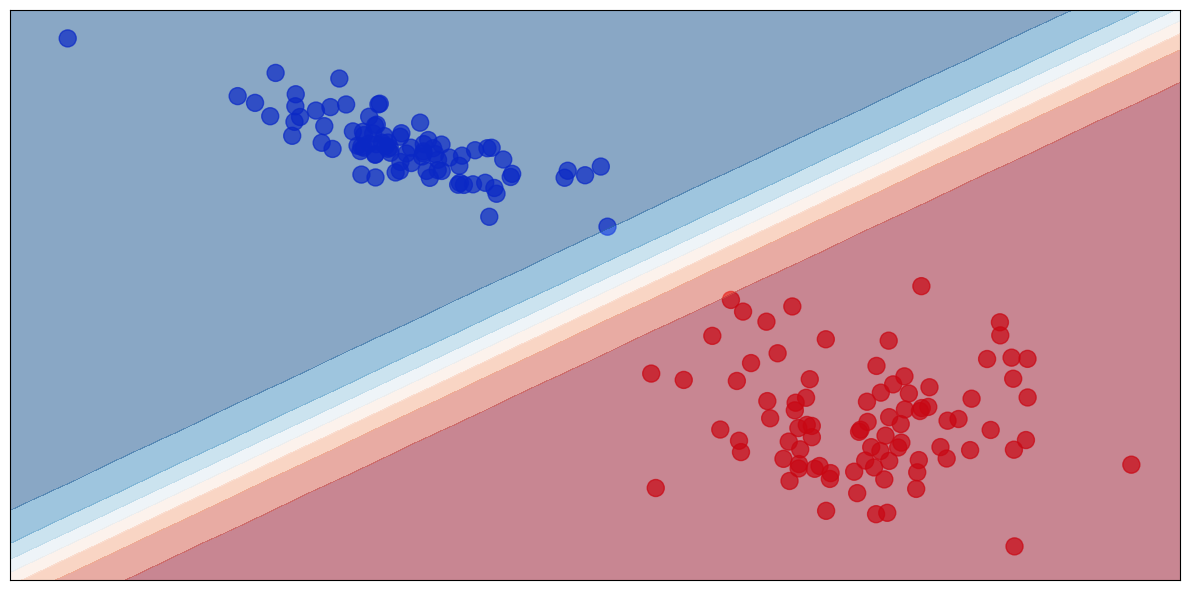

In [18]:
regr.plot_desicion_function(linear_1_x, linear_1_y)

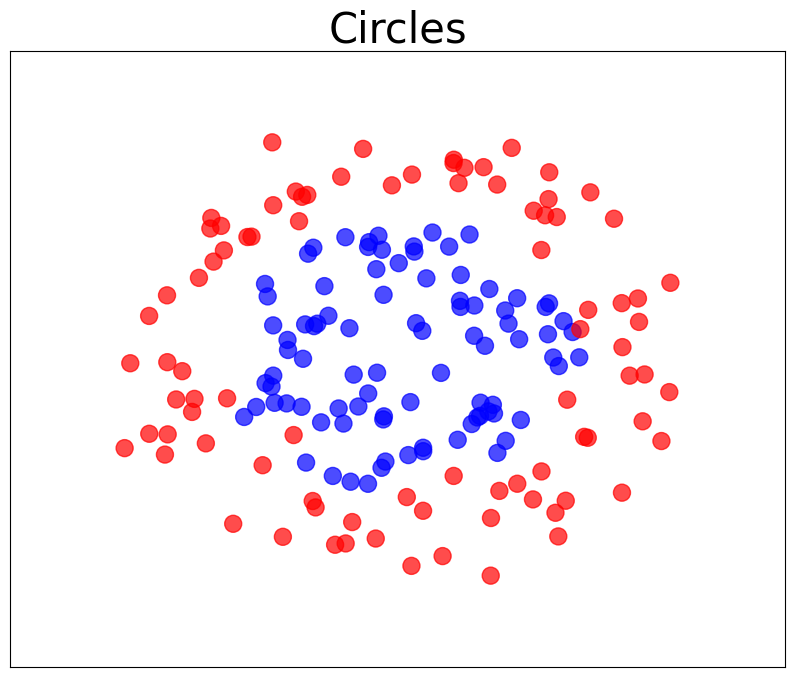

In [19]:
X_train, X_test, y_train, y_test = train_test_split(circles_1_x, circles_1_y, test_size=0.3, random_state=random_state)

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax, (circles_1_x, circles_1_y), 'Circles')

In [20]:
X_poly = to_polynom(circles_1_x, order = 2)

X_train, X_test, y_train, y_test = train_test_split(X_poly, circles_1_y, test_size=0.3, random_state=42)

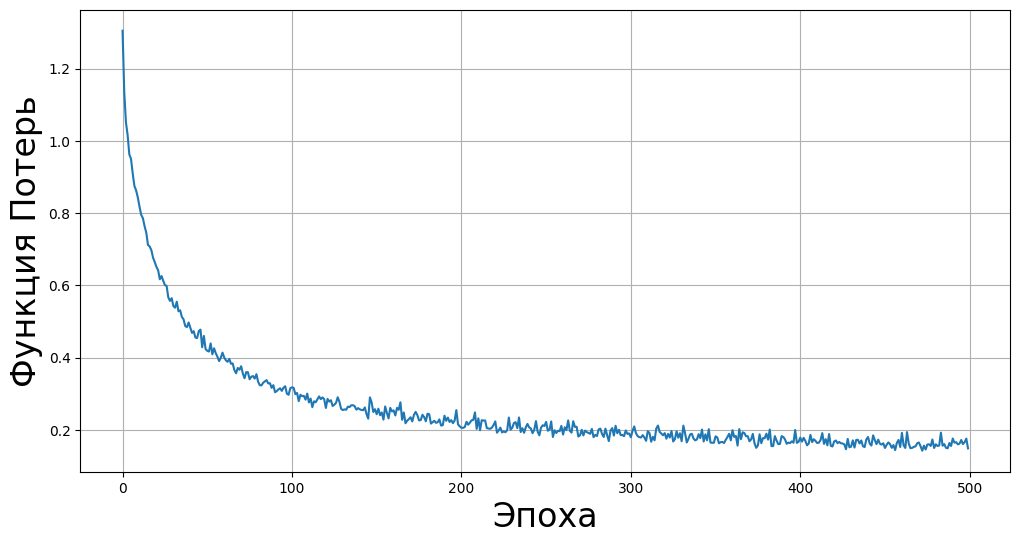

0.9622641509433962 0.9836065573770492
True Positives:0.9355	True Negatives:1.0000
False Positives:0.0645	False Negatives:0.0000
Accuracy:0.9623
Recall:1.0000	Precision:0.9355
f1 measure:0.9667


In [21]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)
regr.plot_cost()
print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

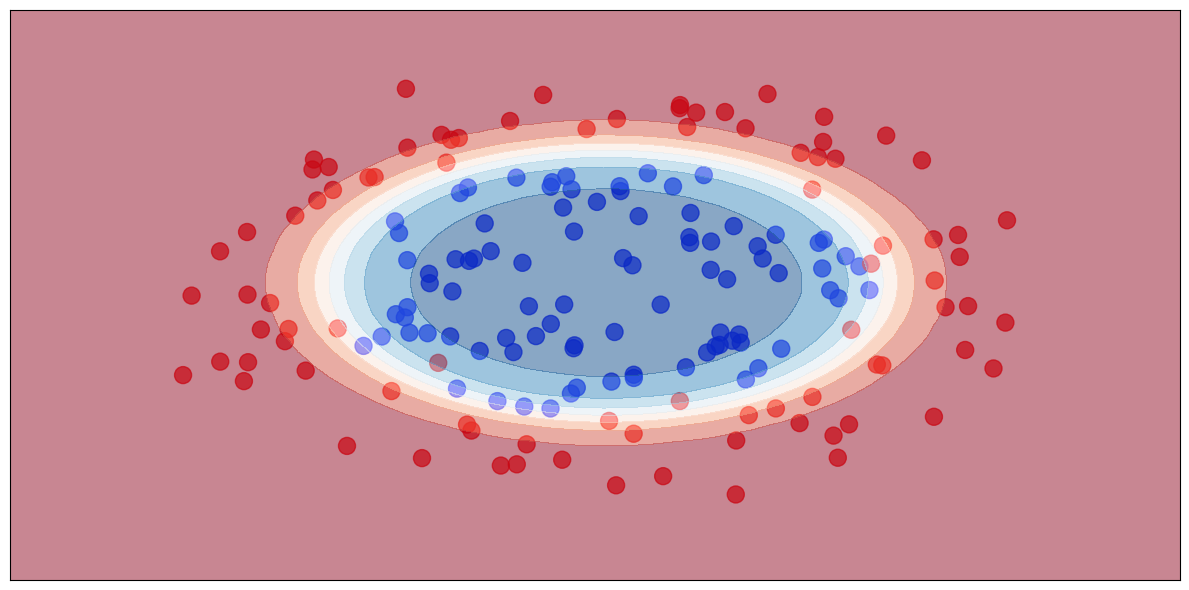

In [22]:
regr.plot_desicion_function(X_poly, circles_1_y, poly = True, order = 2)

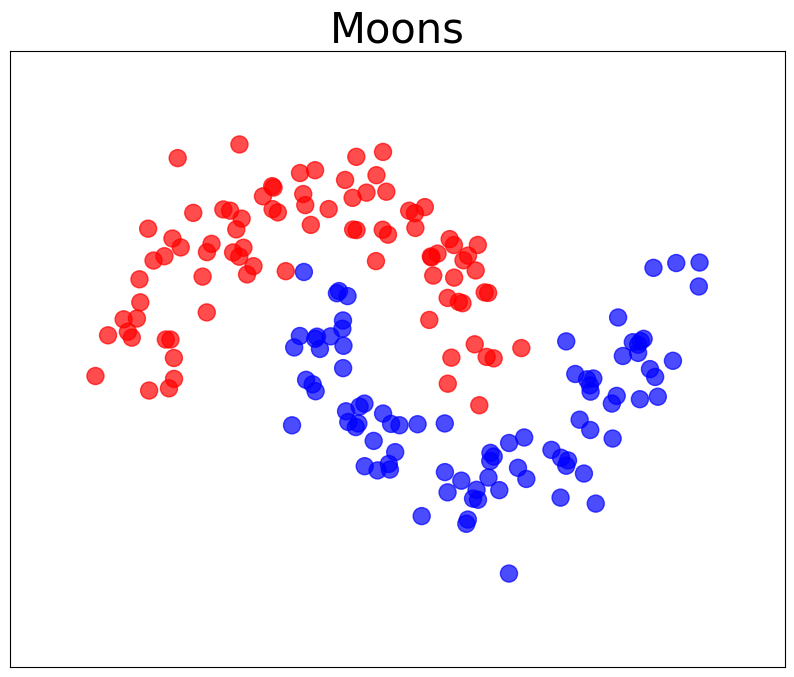

In [23]:
X_train, X_test, y_train, y_test = train_test_split(moons_1_x, moons_1_y, test_size=0.3, random_state=random_state)

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax, (moons_1_x, moons_1_y), 'Moons')

In [24]:
poly_order = 3

In [25]:
X_poly = to_polynom(moons_1_x, order=poly_order)

X_train, X_test, y_train, y_test = train_test_split(X_poly, moons_1_y, test_size=0.3, random_state=42)

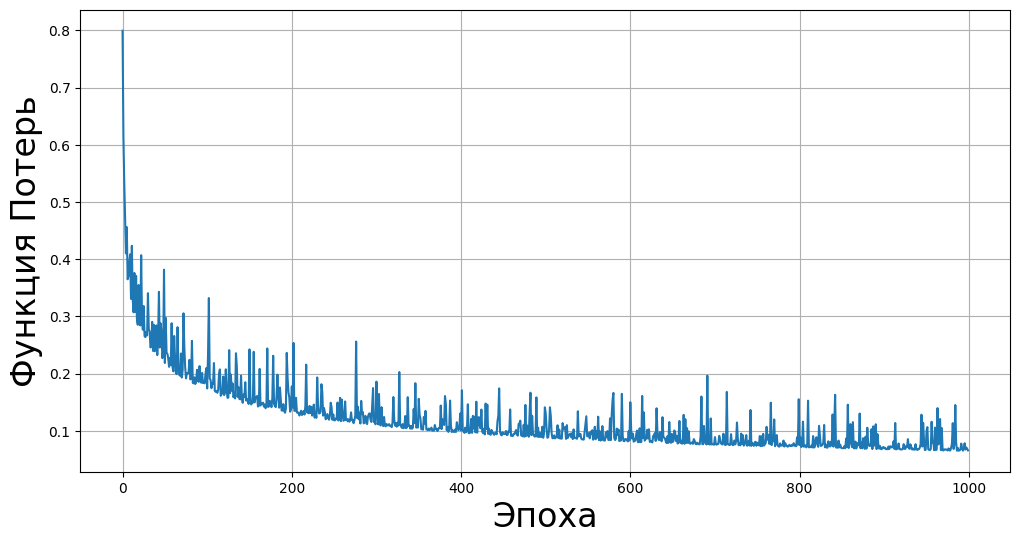

0.9811320754716981 0.9836065573770492
True Positives:0.9667	True Negatives:1.0000
False Positives:0.0333	False Negatives:0.0000
Accuracy:0.9811
Recall:1.0000	Precision:0.9667
f1 measure:0.9831


In [26]:
regr = LogisticRegression(learning_rate=0.1, epochs=1000, batch_size=20)

regr.fit(X_train, y_train)
regr.plot_cost()
print(regr.score(X_test, y_test), regr.score(X_train, y_train))
regr.classification_report(X_test, y_test)

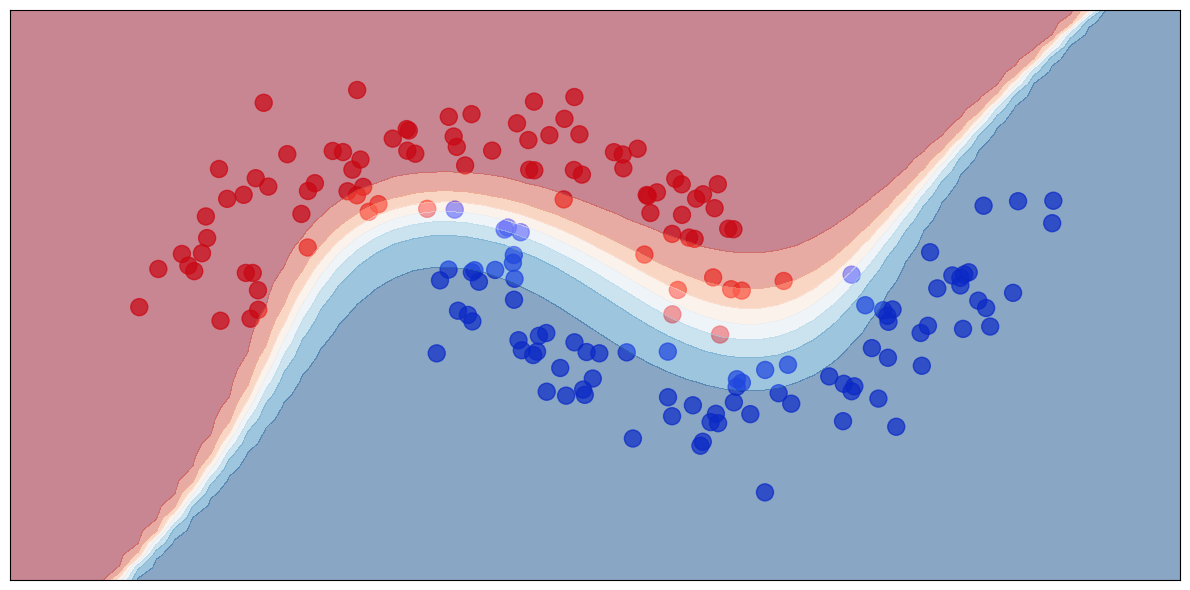

In [27]:
regr.plot_desicion_function(X_poly, moons_1_y, poly=True, order=poly_order)

## 2. Cars moldova logistic regression

### 2.1 Data load

In [28]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [29]:
df = pd.read_csv("https://raw.githubusercontent.com/modernpacifist/engineering-of-machine-learning-urfu/master/math-basics-of-machine-learning/Datasets/cars_moldova_clean.csv", delimiter=",")

In [30]:
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636
...,...,...,...,...,...,...,...,...,...,...,...
32215,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,6,14666.666667
32216,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,20,11250.000000
32217,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0,7,12714.285714
32218,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0,16,23125.000000


In [31]:
df['Transmission'].value_counts()

Manual       17520
Automatic    14700
Name: Transmission, dtype: int64

### 2.2 Cars transmission into numeric type

In [32]:
transmission_map = {'Automatic': 0, 'Manual': 1}
df['Transmission_numeric'] = df['Transmission'].map(transmission_map)

### 2.3 Regression execution

In [33]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

In [34]:
def to_class(logit, threshold = 0.5):
    return (logit >= threshold) * 1

In [35]:
print( to_class(sigmoid(2.5), threshold = 0.7), ',',  to_class(sigmoid(-2.5), threshold = 0.7) )

1 , 0


In [36]:
_EPS_ = 1e-6
def loss(yhat, y):
    return -(y*np.log(yhat + _EPS_)+(1 - y)*np.log(1 - yhat + _EPS_)).mean()

In [37]:
print('неопределенность (yhat=0.5, y=1):\t %.3f'%loss(yhat=0.5, y=1))
print('неопределенность (yhat=0.5, y=0):\t %.3f'%loss(yhat=0.5, y=0))
print('уверенный 0 класс (yhat=0, y=0):\t %.3f'%loss(yhat=0.0, y=0))
print('уверенный 1 класс(yhat=1, y=1):\t %.3f'%loss(yhat=1, y=1))
print('ошибочный 0 класс (yhat=0, y=1):\t %.3f'%loss(yhat=0.0, y=1))
print('ошибочный 1 класс(yhat=1, y=0):\t %.3f'%loss(yhat=1, y=0))

неопределенность (yhat=0.5, y=1):	 0.693
неопределенность (yhat=0.5, y=0):	 0.693
уверенный 0 класс (yhat=0, y=0):	 -0.000
уверенный 1 класс(yhat=1, y=1):	 -0.000
ошибочный 0 класс (yhat=0, y=1):	 13.816
ошибочный 1 класс(yhat=1, y=0):	 13.816


In [38]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    def forward(self, X):
        return self.weights.dot(X.T)
    
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    def grad_step(self, yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    def update(self):    
        return self.weights - self.lr*self.grad
    
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

    def load_batch(self,X,y):
        idx_batch = np.random.randint(0,X.shape[0],self.batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        x_batch   = self.add_bias(x_batch)
        y_batch   = np.take(y, idx_batch)
        return  x_batch, y_batch

    def fit(self, X, y):
        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])

        if self.bias is None: 
            self.bias = self.init(1)

        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad = np.zeros(self.weights.shape)
        self.cost = np.zeros(self.epochs)

        if self.batch_size is None:            
            x_batch = self.add_bias(X)
            y_batch = y
        
        for i in range(self.epochs): 
            if self.batch_size: 
                x_batch, y_batch = self.load_batch(X,y)

            yhat         = self.forward(x_batch)
            self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
            self.weights = self.update()  
            self.cost[i] = self.loss(yhat,  y_batch)

        self.bias = self.weights[0]

    def plot_cost(self, figsize = (12,6)):
        plt.figure(figsize = figsize)
        plt.plot(self.cost,'-*')
        plt.show()

    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [39]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l1_term + l2_term

    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + np.sign(self.weights)* self.l1_penalty + l2_term)

In [40]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 threshold = 0.5,
                 batch_size   = 1000, 
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term 
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z)) 
    
    def forward(self, X):        
        return self.sigmoid(self.weights.dot(X.T))
    
    def to_class(self,logit):
        return (logit>=self.threshold)*1
    
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        
        if self.threshold:
            return self.to_class(yhat)
        else:
            return yhat

    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    
    def classification_report(self, X,y):
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        
        yhat  = self.predict(X)
        total = yhat.size
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.0f'%(tp), end = '\t')
        print('False Positives:%.0f'%(fp))
        print('False Negatives:%.0f'%(fn), end = '\t')
        print('True Negatives:%.0f'%(tn))
        
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp + fn))))

In [41]:
X = df[num_columns].values 
y = df["Transmission_numeric"].values 
features_names = df[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4
22549,0.40,0.011012,0.291667,0.006513,0.005179
22550,0.74,0.208921,0.270833,0.061112,0.297166
22551,0.84,0.155127,0.270833,0.078146,0.343601
22552,0.84,0.219922,0.229167,0.066132,0.487865
22553,0.94,0.049905,0.375000,0.251503,0.248497


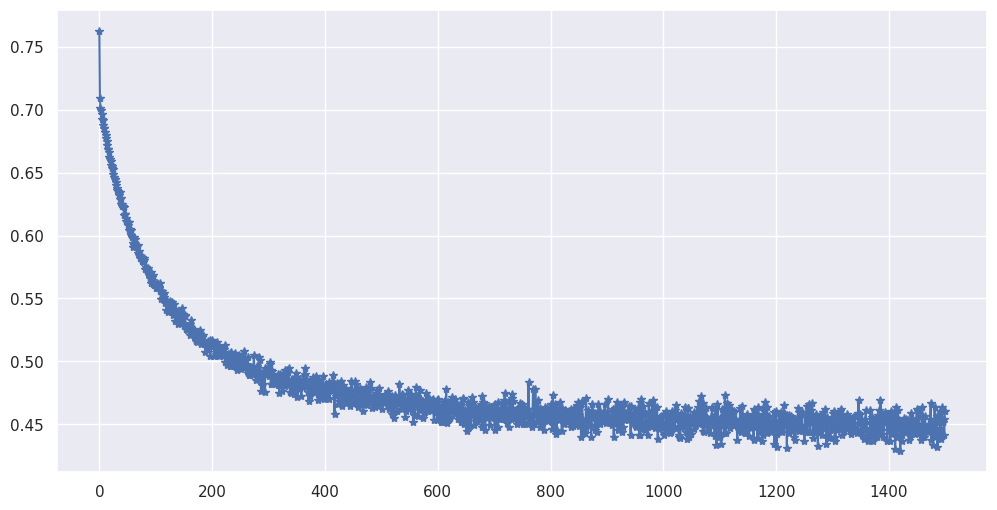

train Accuracy: 0.8066; test Accuracy: 0.8093
True Positives:4550	False Positives:1132
False Negatives:711	True Negatives:3273
Accuracy:0.8093
Recall:0.8649	Precision:0.8008
f1 measure:0.8316


In [42]:
regr = LogisticRegression(learning_rate=0.8, epochs=1500, batch_size=5000)
regr.fit(X_train, y_train)
regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

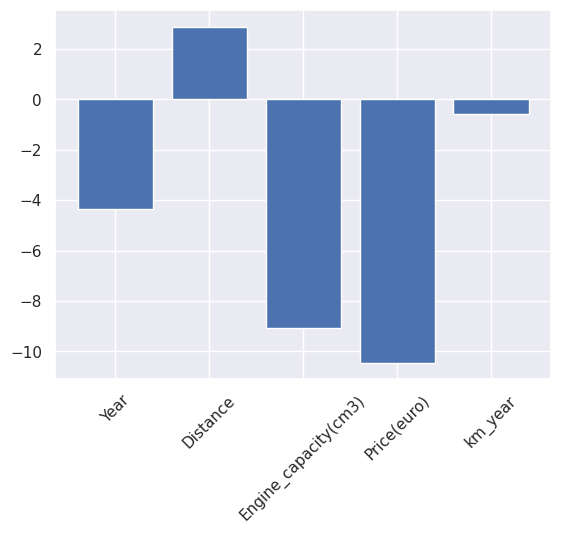

In [43]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size), height=w)
plt.xticks(range(w.size), features_names, rotation = 45);

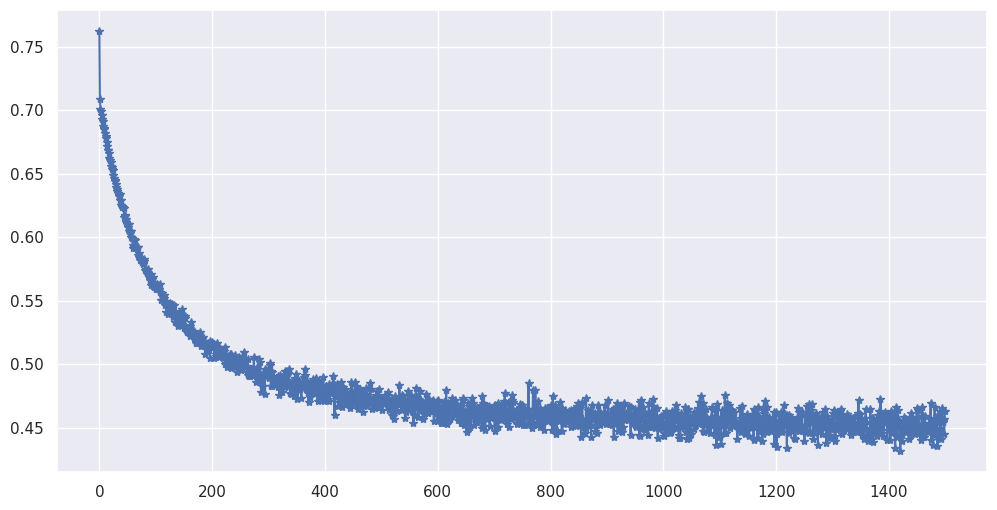

train Accuracy: 0.8048; test Accuracy: 0.8080
True Positives:4540	False Positives:1135
False Negatives:721	True Negatives:3270
Accuracy:0.8080
Recall:0.8630	Precision:0.8000
f1 measure:0.8303


In [44]:
regr = LogisticRegression(learning_rate=0.8, epochs=1500, batch_size=5000, l2_penalty=0.0001)
regr.fit(X_train, y_train)
regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

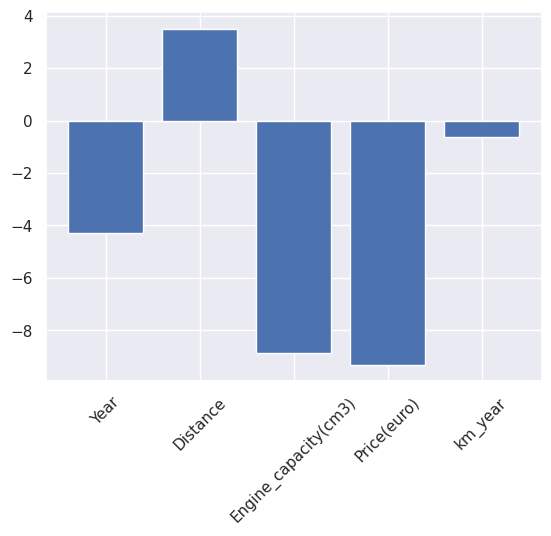

In [45]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size), height=w)
plt.xticks(range(w.size), features_names, rotation = 45);

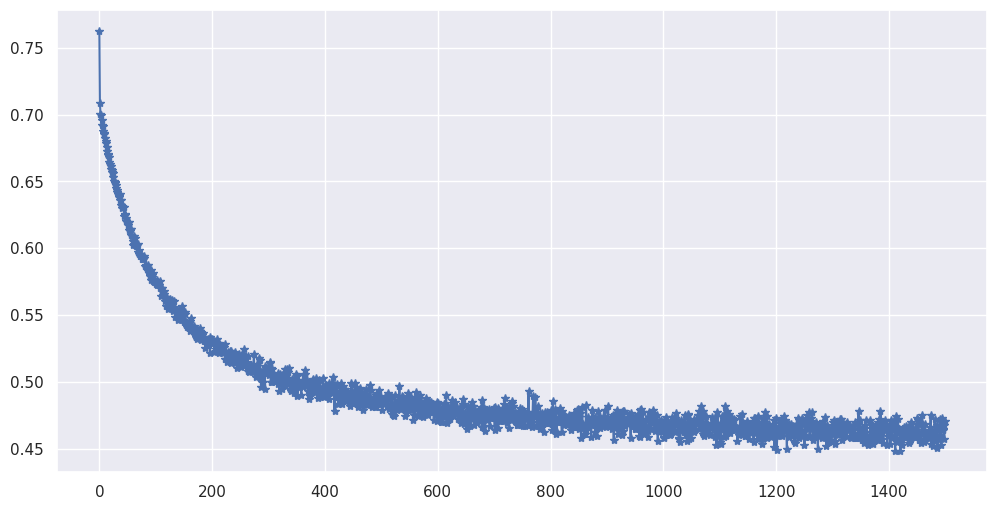

train Accuracy: 0.8070; test Accuracy: 0.8134
True Positives:4639	False Positives:1182
False Negatives:622	True Negatives:3223
Accuracy:0.8134
Recall:0.8818	Precision:0.7969
f1 measure:0.8372


In [46]:
regr = LogisticRegression(learning_rate=0.8, epochs=1500, batch_size=5000, l1_penalty = 0.005)
regr.fit(X_train, y_train)
regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

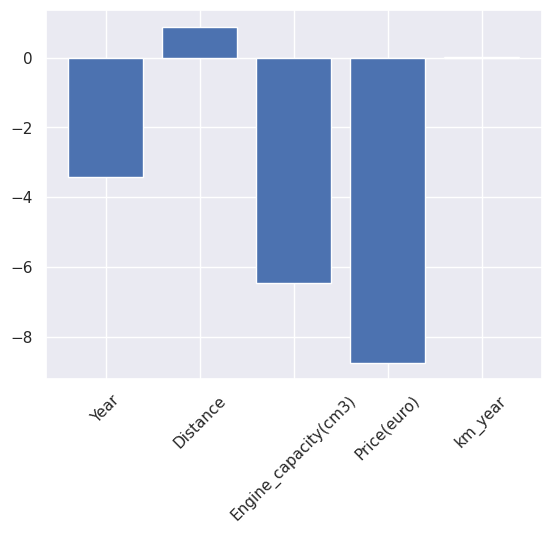

In [47]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

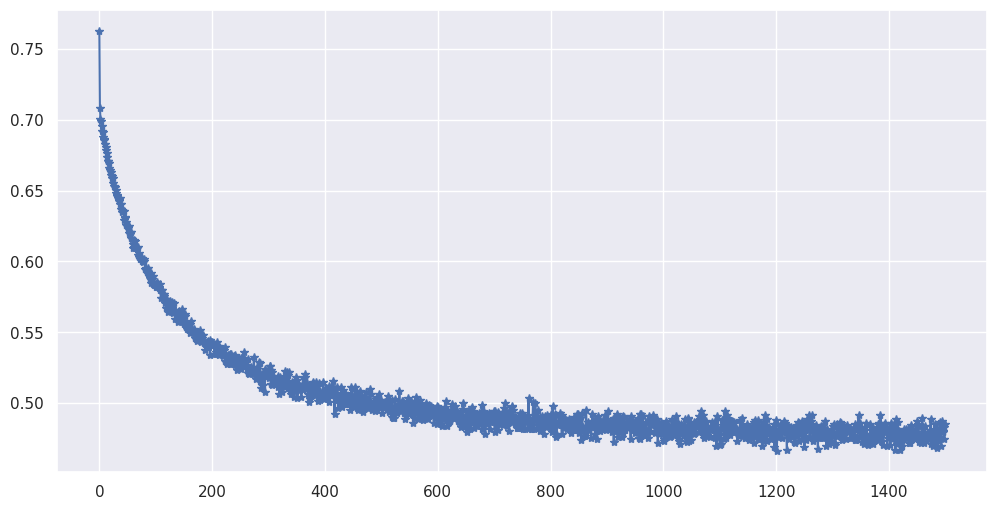

train Accuracy: 0.8062; test Accuracy: 0.8136
True Positives:4686	False Positives:1227
False Negatives:575	True Negatives:3178
Accuracy:0.8136
Recall:0.8907	Precision:0.7925
f1 measure:0.8387


In [48]:
regr = LogisticRegression(learning_rate=0.8, epochs=1500, batch_size=5000, l1_penalty = 0.008, l2_penalty = 0.00005)
regr.fit(X_train, y_train)
regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

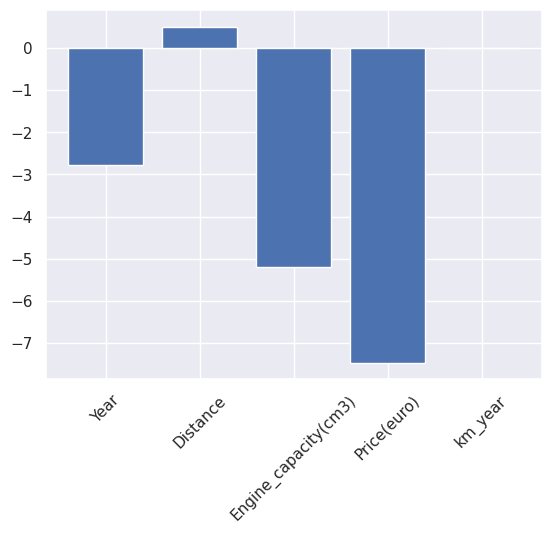

In [49]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

In [50]:
w, b = regr.get_w_and_b()

w[1] = 0
w[-1] = 0

regr = LogisticRegression(learning_rate=0.8,
                          epochs=1500,
                          batch_size=5000, 
                          l1_penalty = 0.005,
                          weights = w,
                          bias = b)


print( 'train ACC: %.4f; test ACC: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

train ACC: 0.8085; test ACC: 0.8157
True Positives:4583	False Positives:1103
False Negatives:678	True Negatives:3302
Accuracy:0.8157
Recall:0.8711	Precision:0.8060
f1 measure:0.8373
